In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

# ----------------------------------------------------------
# Helper functions for confidence intervals
# ----------------------------------------------------------
def compute_auc_ci(y_true, y_score, alpha=0.95):
    """
    Computes AUC and its 95% CI using the Hanley & McNeil (1982) approximation.
    """
    auc_ = roc_auc_score(y_true, y_score)
    # Count of positives and negatives in y_true
    n1 = np.sum(y_true == 1)
    n2 = np.sum(y_true == 0)
    
    # If we have no positives or no negatives, can't compute CI meaningfully
    if n1 == 0 or n2 == 0:
        return auc_, None, None

    # Hanley & McNeil parameters
    Q1 = auc_ / (2 - auc_)
    Q2 = 2 * auc_ * auc_ / (1 + auc_)

    # Standard error
    se = np.sqrt(
        (auc_ * (1 - auc_)
         + (n1 - 1) * (Q1 - auc_**2)
         + (n2 - 1) * (Q2 - auc_**2))
        / (n1 * n2)
    )
    
    # 95% CI using z-score
    z = 1.96
    lower = max(0, auc_ - z * se)
    upper = min(1, auc_ + z * se)
    return auc_, lower, upper


def sensitivity_confidence_interval(tp, fn, z=1.96):
    """
    Computes sensitivity and its 95% CI using the binomial proportion approach:
      p ± z * sqrt(p*(1-p)/n),
    where p = TP / (TP + FN).
    """
    n_pos = tp + fn
    if n_pos == 0:
        # If there are no actual positives, we can't compute a meaningful sensitivity CI.
        return 0, 0, 0

    sens = tp / n_pos
    se = np.sqrt(sens * (1 - sens) / n_pos)
    lower = max(0, sens - z * se)
    upper = min(1, sens + z * se)
    return sens, lower, upper


# ----------------------------------------------------------
# Load dataset
# ----------------------------------------------------------
# Adjust the file path to your environment
# file_path_new = r'/Users/hnguyen/Downloads/AMPICILLIN_E.COLI_12.4.24.csv'
file_path_new = r'C:\Users\Hubert N\Downloads\AMPICILLIN_E.COLI_12.4.24.csv'
df_new = pd.read_csv(file_path_new)

# Define target and features
columns_of_interest_new = [
    "Sex (0 = female; 1 = male)", "Neuter status (0 = castrated; 1 = not castrated)",
    "Age", "Weight (kg)", "Number of vet visits", "Hospitalization (no = 0; yes = 1)",
    "Duration of hospitalization (days)", "Antimicrobial therapy (no = 0; yes = 1)",
    "Duration of therapy (days)", "Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)",
    "Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)", "USG", "PH", "Protein",
    "Glucose", "Ketones", "Bilirubin...19", "Hemoprotein", 
    "Lipid Layer", "WBC (simplified)", "Pyuria (1 if >/=4)", "RBC (simplified)",
    "Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)", "Casts-Hyaline",
    "Casts-Granular", "Bacteria quantity", "Bac Type", "Lipid Droplets", "Sperm"
]

df_new = df_new[df_new["Ampicillin_RSI"].isin(["R", "S"])]
df_new['Ampicillin_RSI'] = df_new['Ampicillin_RSI'].map({'S': 0, 'R': 1})
target_new = df_new['Ampicillin_RSI']
features_new = df_new[columns_of_interest_new]

# Count and percentage of R vs. S cases
r_count = df_new['Ampicillin_RSI'].sum()  # Count of R cases
s_count = len(df_new) - r_count           # Count of S cases
print(f"Count of 'R' cases: {r_count}")
print(f"Count of 'S' cases: {s_count}")
print(f"Percentage of 'R' cases: {r_count / len(df_new) * 100:.2f}%")
print(f"Percentage of 'S' cases: {s_count / len(df_new) * 100:.2f}%")

# Separate categorical and numerical columns
categorical_cols_new = [
    "Sex (0 = female; 1 = male)", "Neuter status (0 = castrated; 1 = not castrated)",
    "Hospitalization (no = 0; yes = 1)", "Antimicrobial therapy (no = 0; yes = 1)",
    "Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)",
    "Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)", "Pyuria (1 if >/=4)",
    "Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)", "Casts-Hyaline",
    "Casts-Granular", "Bacteria quantity", "Bac Type", "Lipid Droplets", "Sperm"
]
categorical_cols_new = [col for col in categorical_cols_new if col in features_new.columns]
numerical_cols_new = [col for col in features_new.columns if col not in categorical_cols_new]

# Impute missing values
for col in numerical_cols_new:
    features_new[col] = pd.to_numeric(features_new[col], errors='coerce')
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
features_new[numerical_cols_new] = imputer_num.fit_transform(features_new[numerical_cols_new])
features_new[categorical_cols_new] = imputer_cat.fit_transform(features_new[categorical_cols_new])

# Scale numerical features and encode categorical features
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
features_new[numerical_cols_new] = scaler.fit_transform(features_new[numerical_cols_new])
encoded_cat_new = pd.DataFrame(
    encoder.fit_transform(features_new[categorical_cols_new]),
    index=features_new.index
)
encoded_cat_new.columns = encoder.get_feature_names_out(categorical_cols_new)
features_preprocessed_new = pd.concat(
    [features_new[numerical_cols_new], encoded_cat_new],
    axis=1
)

# Feature selection
rf = RandomForestClassifier(random_state=42)
rf.fit(features_preprocessed_new, target_new)
selector = SelectFromModel(rf, threshold='median', prefit=True)
features_selected_new = selector.transform(features_preprocessed_new)
selected_feature_names = features_preprocessed_new.columns[selector.get_support()]
features_final_new = pd.DataFrame(
    features_selected_new,
    columns=selected_feature_names,
    index=features_preprocessed_new.index
)

# Handle class imbalance
oversampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}
best_auc = 0
X_resampled_final, y_resampled_final = None, None

for name, sampler in oversampling_methods.items():
    X_resampled, y_resampled = sampler.fit_resample(features_final_new, target_new)
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, stratify=y_resampled
    )
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    if auc_score > best_auc:
        best_auc, X_resampled_final, y_resampled_final = auc_score, X_resampled, y_resampled

# Percentage of data used for training vs. testing
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size
print(f"Training set size: {train_size} cases ({train_size / total_size * 100:.2f}%)")
print(f"Testing set size: {test_size} cases ({test_size / total_size * 100:.2f}%)")

# Final datasets (from the best oversampler)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_final, y_resampled_final, test_size=0.2, stratify=y_resampled_final
)

# Train and evaluate models
models = {
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),  # Suppress warnings
    'XGBoost': xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, eval_metric='AUC', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

model_aucs = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    model_aucs[name] = auc_score
    print(f"{name} AUC: {auc_score:.4f}")

# Optuna hyperparameter tuning for LightGBM
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'verbose': -1  # Suppress warnings
    }
    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    return roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Train the optimized LightGBM model
best_lgbm = lgb.LGBMClassifier(**study.best_params, random_state=42, verbose=-1)
best_lgbm.fit(X_train, y_train)
auc_lgbm = roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])
print(f"Optimized LightGBM AUC: {auc_lgbm:.4f}")

Count of 'R' cases: 124
Count of 'S' cases: 403
Percentage of 'R' cases: 23.53%
Percentage of 'S' cases: 76.47%
Training set size: 372 cases (80.00%)
Testing set size: 93 cases (20.00%)
LightGBM AUC: 0.9916
XGBoost AUC: 0.9893


[I 2025-01-27 16:20:34,768] A new study created in memory with name: no-name-74d9c1f4-dd67-41a4-b713-dd34aeb2be48
[I 2025-01-27 16:20:34,805] Trial 0 finished with value: 0.9590347923681257 and parameters: {'max_depth': 8, 'num_leaves': 85, 'learning_rate': 0.013735733801850232, 'n_estimators': 117}. Best is trial 0 with value: 0.9590347923681257.
[I 2025-01-27 16:20:34,893] Trial 1 finished with value: 0.9870931537598204 and parameters: {'max_depth': 7, 'num_leaves': 62, 'learning_rate': 0.06958936305942053, 'n_estimators': 481}. Best is trial 1 with value: 0.9870931537598204.
[I 2025-01-27 16:20:34,979] Trial 2 finished with value: 0.9876543209876544 and parameters: {'max_depth': 5, 'num_leaves': 55, 'learning_rate': 0.011901530505001704, 'n_estimators': 469}. Best is trial 2 with value: 0.9876543209876544.


CatBoost AUC: 0.9933
LogisticRegression AUC: 0.8900


[I 2025-01-27 16:20:35,068] Trial 3 finished with value: 0.9887766554433222 and parameters: {'max_depth': 8, 'num_leaves': 43, 'learning_rate': 0.02771557693568054, 'n_estimators': 412}. Best is trial 3 with value: 0.9887766554433222.
[I 2025-01-27 16:20:35,122] Trial 4 finished with value: 0.9876543209876543 and parameters: {'max_depth': 5, 'num_leaves': 26, 'learning_rate': 0.06250308932932656, 'n_estimators': 335}. Best is trial 3 with value: 0.9887766554433222.
[I 2025-01-27 16:20:35,179] Trial 5 finished with value: 0.9876543209876544 and parameters: {'max_depth': 7, 'num_leaves': 42, 'learning_rate': 0.020350125395124673, 'n_estimators': 315}. Best is trial 3 with value: 0.9887766554433222.
[I 2025-01-27 16:20:35,220] Trial 6 finished with value: 0.9523007856341191 and parameters: {'max_depth': 7, 'num_leaves': 25, 'learning_rate': 0.006210794429714625, 'n_estimators': 193}. Best is trial 3 with value: 0.9887766554433222.
[I 2025-01-27 16:20:35,274] Trial 7 finished with value: 0

Optimized LightGBM AUC: 0.9899


Training LightGBM...

LightGBM Performance:
AUC: 0.9916 (95% CI: [0.9754, 1.0000])
Sensitivity: 0.9697 (95% CI: [0.9283, 1.0000])
Specificity: 0.9630 (95% CI: [0.8917, 1.0000])
Accuracy: 0.9677 (95% CI: [0.9318, 1.0000])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    64                     2
Negative (Actual)                     1                    26


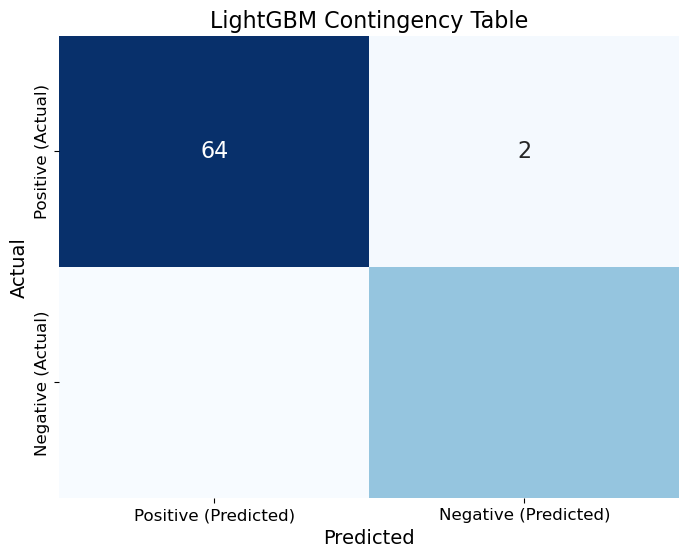


Features used in the model and their importance:
                                              Feature  Importance
1                                         Weight (kg)         175
0                                                 Age         162
5                                                 USG         148
2                                Number of vet visits          82
12                                   WBC (simplified)          82
6                                                  PH          79
4                          Duration of therapy (days)          76
7                                             Protein          66
13                                   RBC (simplified)          56
10                                        Hemoprotein          54
23  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...          53
29                              Bacteria quantity_3.0          52
11                                        Lipid Layer          33
20        Antimicrobial th

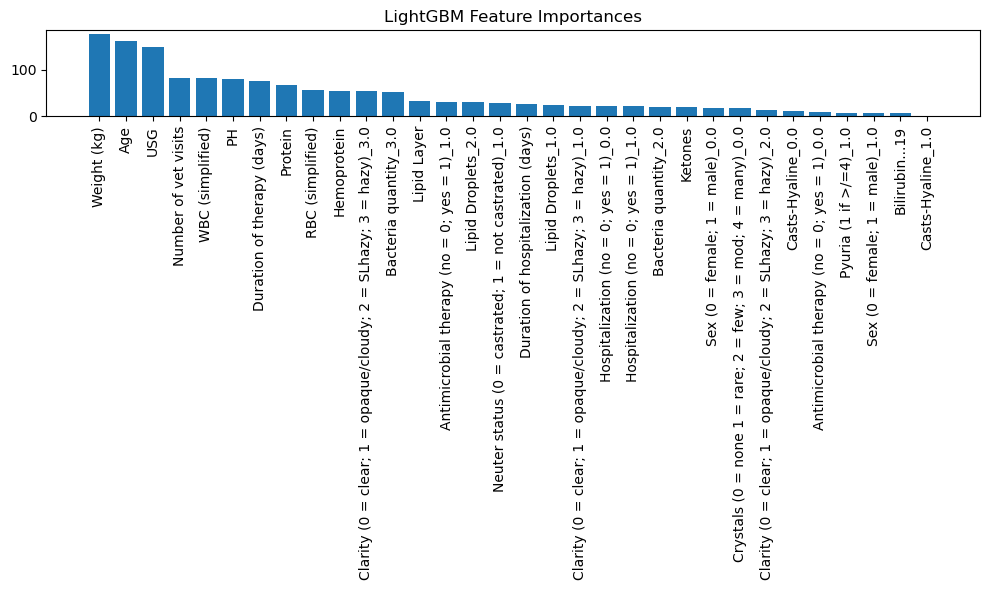

Training XGBoost...

XGBoost Performance:
AUC: 0.9893 (95% CI: [0.9711, 1.0000])
Sensitivity: 0.9848 (95% CI: [0.9554, 1.0000])
Specificity: 0.8148 (95% CI: [0.6683, 0.9613])
Accuracy: 0.9355 (95% CI: [0.8856, 0.9854])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    65                     1
Negative (Actual)                     5                    22


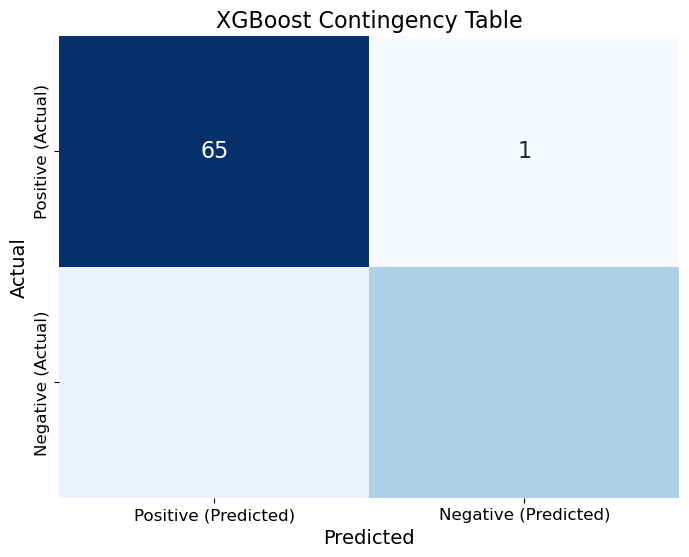


Features used in the model and their importance:
                                              Feature  Importance
24                             Pyuria (1 if >/=4)_1.0    0.187237
19        Antimicrobial therapy (no = 0; yes = 1)_0.0    0.125814
23  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    0.100826
4                          Duration of therapy (days)    0.071288
8                                             Ketones    0.064583
30                                 Lipid Droplets_1.0    0.039109
2                                Number of vet visits    0.034356
27                                  Casts-Hyaline_1.0    0.034270
28                              Bacteria quantity_2.0    0.026524
3                  Duration of hospitalization (days)    0.026478
14                     Sex (0 = female; 1 = male)_0.0    0.026199
13                                   RBC (simplified)    0.022147
11                                        Lipid Layer    0.020694
1                         

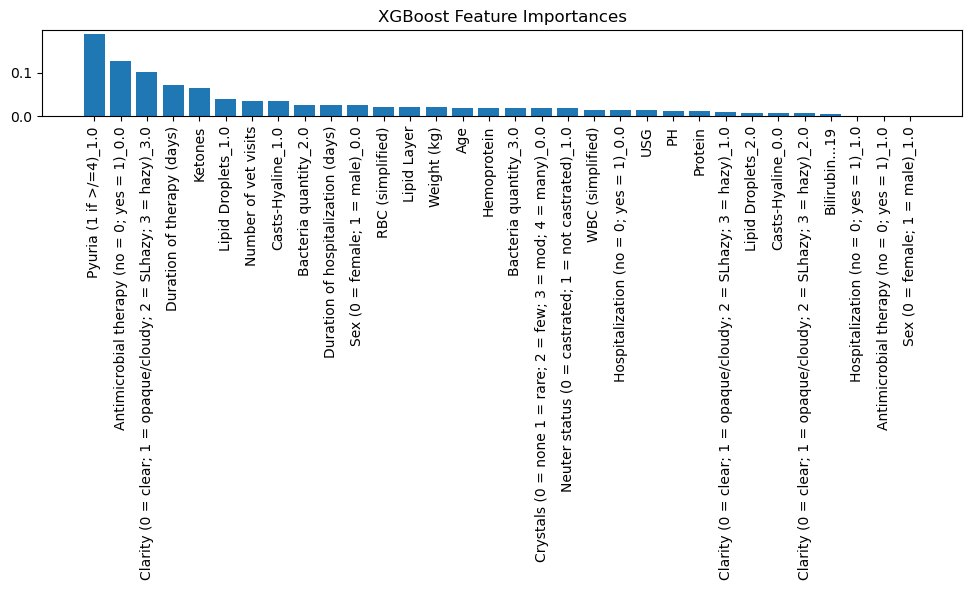

Training CatBoost...

CatBoost Performance:
AUC: 0.9933 (95% CI: [0.9789, 1.0000])
Sensitivity: 0.9848 (95% CI: [0.9554, 1.0000])
Specificity: 0.7778 (95% CI: [0.6210, 0.9346])
Accuracy: 0.9247 (95% CI: [0.8711, 0.9784])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    65                     1
Negative (Actual)                     6                    21


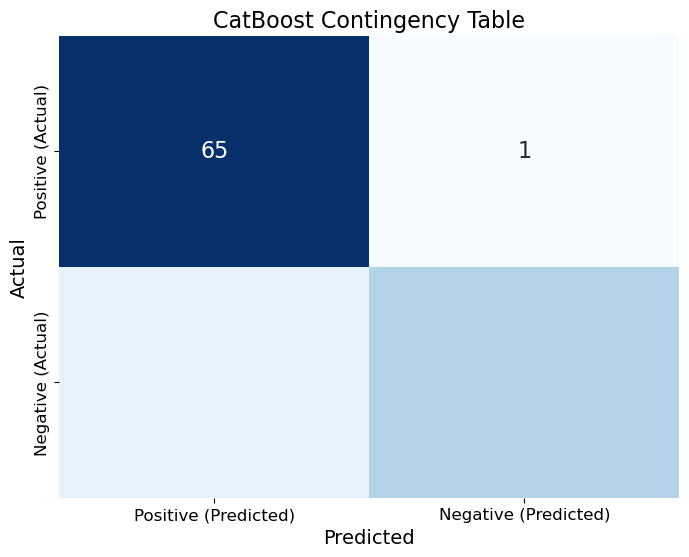


Features used in the model and their importance:
                                              Feature  Importance
23  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    8.103775
19        Antimicrobial therapy (no = 0; yes = 1)_0.0    6.132292
0                                                 Age    5.736943
20        Antimicrobial therapy (no = 0; yes = 1)_1.0    5.716369
1                                         Weight (kg)    5.665475
6                                                  PH    4.969625
2                                Number of vet visits    4.825496
12                                   WBC (simplified)    4.596581
29                              Bacteria quantity_3.0    4.150547
4                          Duration of therapy (days)    3.965690
11                                        Lipid Layer    3.615040
5                                                 USG    3.262304
21  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    3.191167
10                        

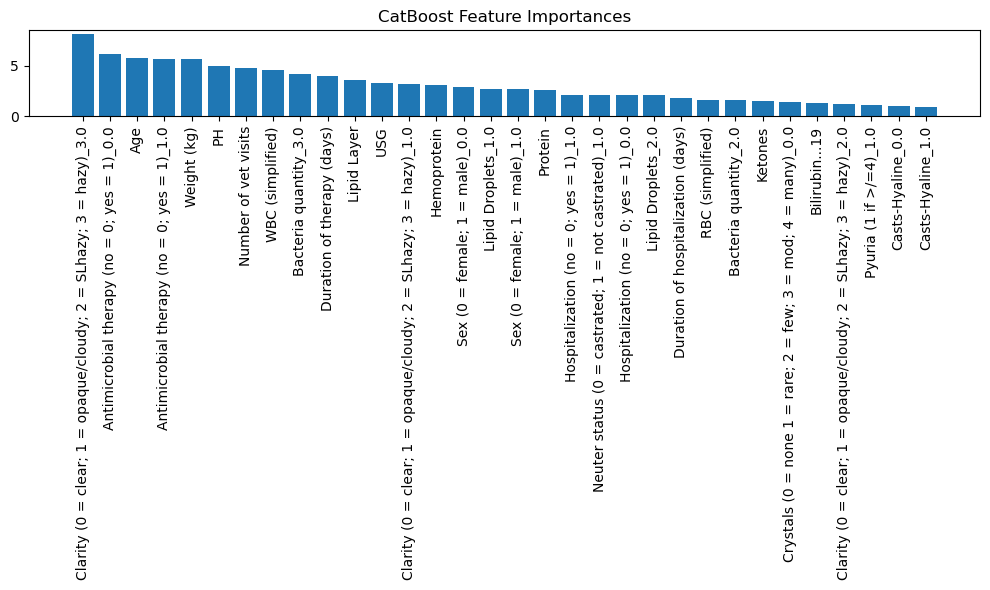

Training LogisticRegression...

LogisticRegression Performance:
AUC: 0.8900 (95% CI: [0.8256, 0.9545])
Sensitivity: 0.9091 (95% CI: [0.8397, 0.9784])
Specificity: 0.6667 (95% CI: [0.4889, 0.8445])
Accuracy: 0.8387 (95% CI: [0.7640, 0.9135])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    60                     6
Negative (Actual)                     9                    18


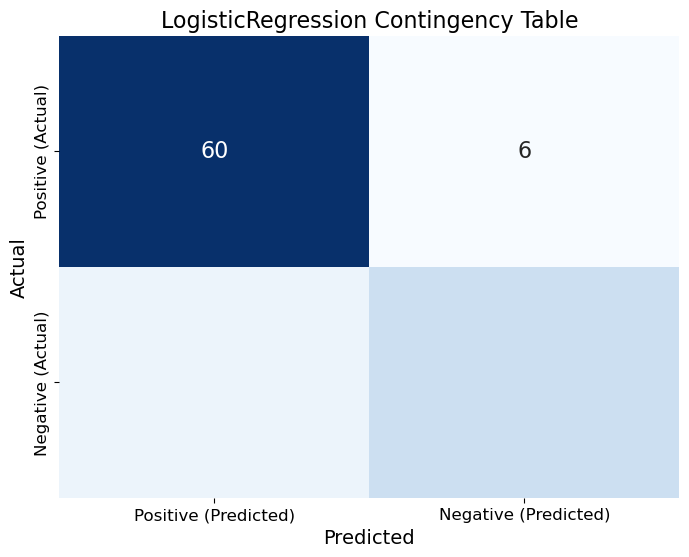


Features used in the model and their coefficients:
                                              Feature  Coefficient
23  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...     1.378466
27                                  Casts-Hyaline_1.0     0.756334
26                                  Casts-Hyaline_0.0     0.683329
4                          Duration of therapy (days)     0.597158
24                             Pyuria (1 if >/=4)_1.0     0.514041
20        Antimicrobial therapy (no = 0; yes = 1)_1.0     0.423249
25  Crystals (0 = none 1 = rare; 2 = few; 3 = mod;...     0.411138
28                              Bacteria quantity_2.0     0.331705
11                                        Lipid Layer     0.292640
8                                             Ketones     0.251418
7                                             Protein     0.217114
21  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...     0.204713
14                     Sex (0 = female; 1 = male)_0.0     0.141816
2         

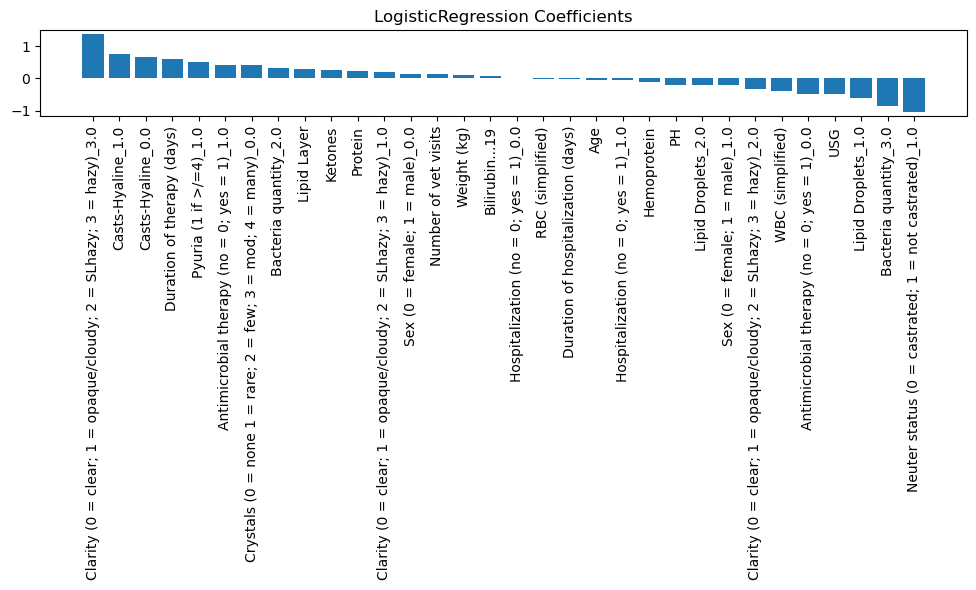

In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  # Retrain to ensure consistency in final eval
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # -------------------
    # AUC + AUC CI
    # -------------------
    auc_val, auc_lower, auc_upper = compute_auc_ci(y_test, y_pred_proba)
    
    # -------------------
    # Sensitivity + CI
    # -------------------
    sens, sens_lower, sens_upper = sensitivity_confidence_interval(tp, fn)
    
    # -------------------
    # Specificity
    # -------------------
    specificity = tn / (tn + fp) if (tn + fp) else 0
    
    # -------------------
    # Accuracy
    # -------------------
    accuracy = accuracy_score(y_test, y_pred)
    
    # 95% CI for accuracy (already in code)
    z = 1.96
    n = len(y_test)
    p = accuracy
    ci_lower_acc = max(0, p - z * np.sqrt((p * (1 - p)) / n))
    ci_upper_acc = min(1, p + z * np.sqrt((p * (1 - p)) / n))
    
    # 95% CI for specificity (already in code)
    neg = tn + fp
    spec_ci_lower = 0
    spec_ci_upper = 1
    if neg > 0:
        spec_ci_lower = max(0, specificity - z * np.sqrt((specificity * (1 - specificity)) / neg))
        spec_ci_upper = min(1, specificity + z * np.sqrt((specificity * (1 - specificity)) / neg))
    
    # Print performance
    print(f"\n{name} Performance:")
    # AUC
    if auc_lower is not None and auc_upper is not None:
        print(f"AUC: {auc_val:.4f} (95% CI: [{auc_lower:.4f}, {auc_upper:.4f}])")
    else:
        print(f"AUC: {auc_val:.4f} (Not enough data for CI)")
    # Sensitivity
    print(f"Sensitivity: {sens:.4f} (95% CI: [{sens_lower:.4f}, {sens_upper:.4f}])")
    # Specificity
    print(f"Specificity: {specificity:.4f} (95% CI: [{spec_ci_lower:.4f}, {spec_ci_upper:.4f}])")
    # Accuracy
    print(f"Accuracy: {accuracy:.4f} (95% CI: [{ci_lower_acc:.4f}, {ci_upper_acc:.4f}])")
    
    # Contingency table (2x2 table)
    print("\nContingency Table:")
    contingency_table = pd.DataFrame(
        [[tp, fn],
         [fp, tn]],
        columns=["Positive (Predicted)", "Negative (Predicted)"],
        index=["Positive (Actual)", "Negative (Actual)"]
    )
    print(contingency_table)
    
    # Heatmap of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        contingency_table,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 16}
    )
    plt.title(f"{name} Contingency Table", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    # Feature importances or coefficients
    if hasattr(model, "feature_importances_"):
        print("\nFeatures used in the model and their importance:")
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": selected_feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(feature_importance_df)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importances")
        plt.bar(range(len(importances)), feature_importance_df["Importance"], align="center")
        plt.xticks(range(len(importances)), feature_importance_df["Feature"], rotation=90)
        plt.tight_layout()
        plt.show()
    
    elif name == "LogisticRegression":
        print("\nFeatures used in the model and their coefficients:")
        importances = model.coef_[0]  # shape: (1, n_features) for binary classification
        feature_importance_df = pd.DataFrame({
            "Feature": selected_feature_names,
            "Coefficient": importances
        }).sort_values(by="Coefficient", ascending=False)
        print(feature_importance_df)
        
        # Plot coefficients
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Coefficients")
        plt.bar(range(len(importances)), feature_importance_df["Coefficient"], align="center")
        plt.xticks(range(len(importances)), feature_importance_df["Feature"], rotation=90)
        plt.tight_layout()
        plt.show()